In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud
import re
import string
import unicodedata

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
['IMDB Dataset.csv']


## Load data

In [3]:
df = pd.read_csv(path + '/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,0
review,0
sentiment,0


In [5]:
df = df.rename(columns={'sentiment' : 'label'})
df.head()

,review,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df['review_len'] = df['review'].apply(lambda x: len(x.split(' ')))
df.head()

,review,label,review_len
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


## EDA

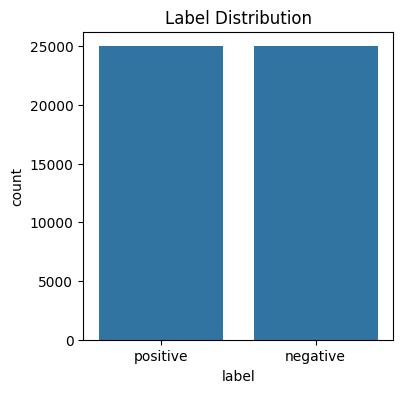

In [7]:
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

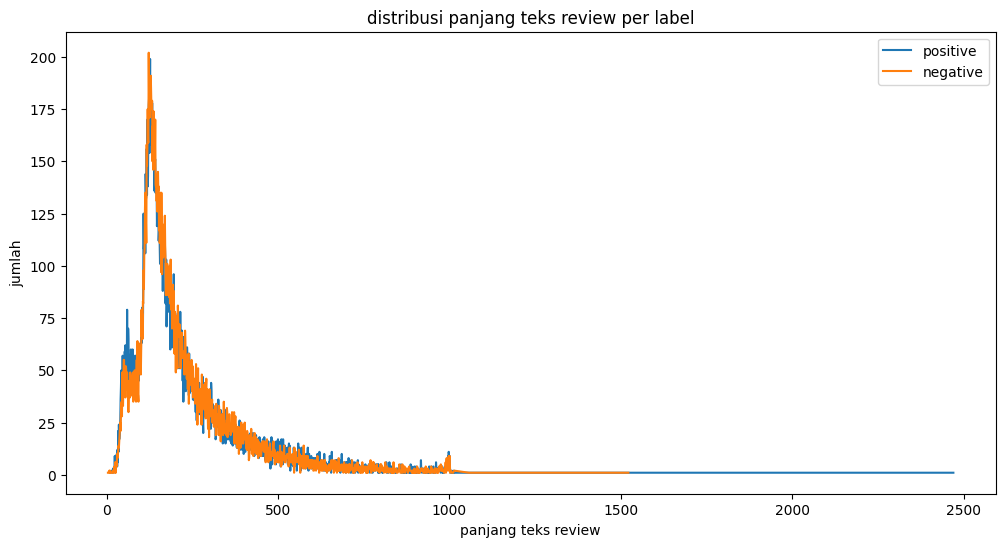

In [8]:
positive_df = df[df['label'] == 'positive']['review_len'].value_counts().sort_index()
negative_df = df[df['label'] == 'negative']['review_len'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(positive_df.index, positive_df.values, label='positive')
plt.plot(negative_df.index, negative_df.values, label='negative')
plt.title('distribusi panjang teks review per label')
plt.xlabel('panjang teks review')
plt.ylabel('jumlah')
plt.legend()
plt.show()

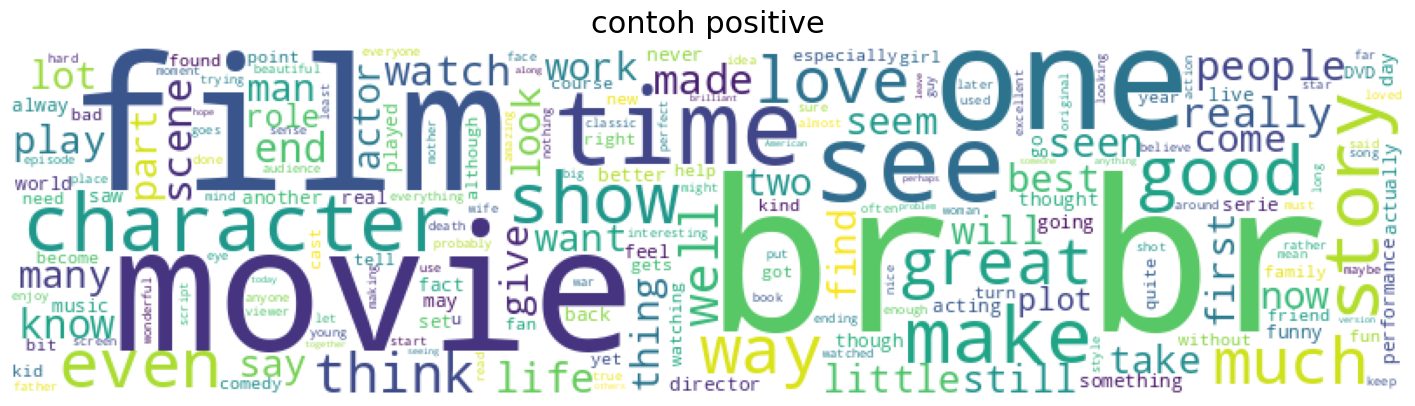

In [9]:
wc = WordCloud(
    background_color = 'white',
    width = 800
)

wc.generate(' '.join(text for text in df.loc[df['label'] == 'positive', 'review']))
plt.figure(figsize=(18,10))
plt.title('contoh positive',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

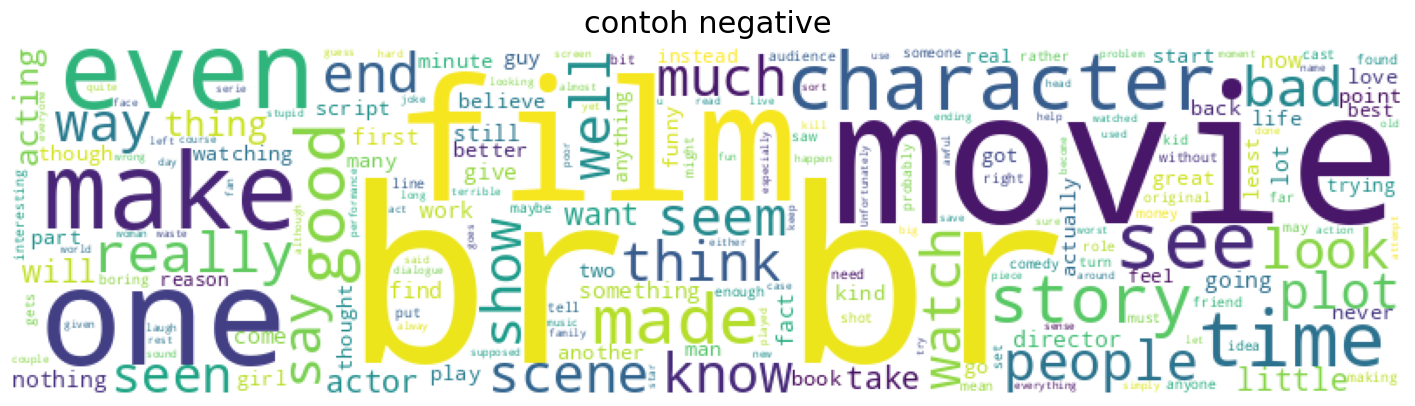

In [10]:
wc = WordCloud(
    background_color = 'white',
    width = 800
)

wc.generate(' '.join(text for text in df.loc[df['label'] == 'negative', 'review']))
plt.figure(figsize=(18,10))
plt.title('contoh negative',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

## Preprocess


cleaning review text

In [11]:
def clean_review(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [12]:
df['clean_review'] = df['review'].apply(lambda x: clean_review(x))
df.head()

,review,label,review_len,clean_review
0,One of the other reviewers has mentioned that ...,positive,307,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,162,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,166,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,138,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love in the time of money is a ...


stopwords

In [13]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
  text = ' '.join([word for word in str(text).split() if word not in stop_words])
  return text

df['clean_review'] = df['clean_review'].apply(lambda x: remove_stopwords(x))
df.head(

)

,review,label,review_len,clean_review
0,One of the other reviewers has mentioned that ...,positive,307,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,138,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love time money visually stunni...


lemmatizer

In [14]:
lemmatizer = nltk.WordNetLemmatizer()

def lem_text(text):
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
  return text

df['clean_review'] = df['clean_review'].apply(lambda x: lem_text(x))
df.head()

,review,label,review_len,clean_review
0,One of the other reviewers has mentioned that ...,positive,307,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,138,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love time money visually stunni...


label encoder

In [15]:
le = LabelEncoder()
le.fit(df['label'])

df['label'] = le.transform(df['label'])
df.head()

,review,label,review_len,clean_review
0,One of the other reviewers has mentioned that ...,1,307,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,1,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,138,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,petter matteis love time money visually stunni...


visualisasi token

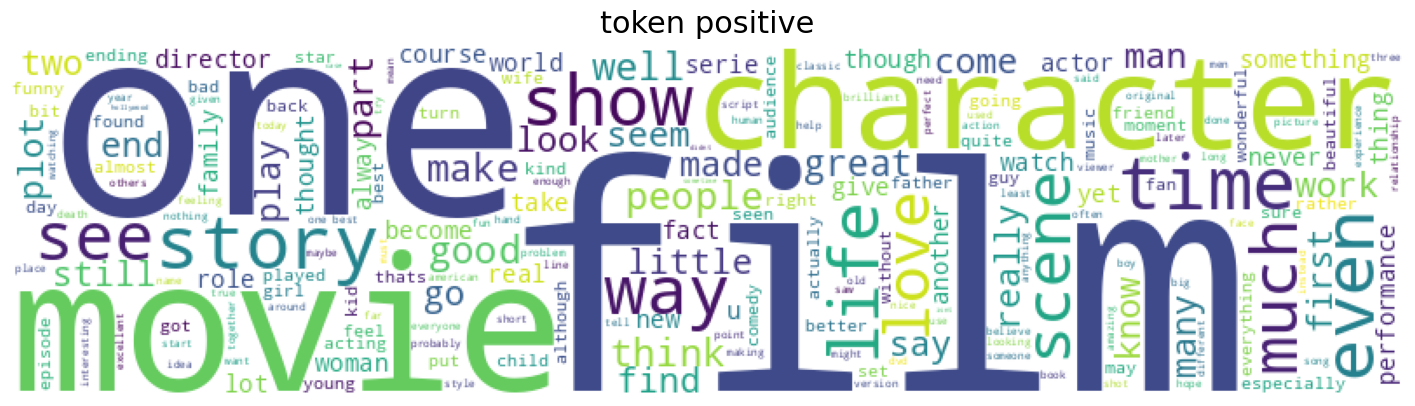

In [16]:
wc = WordCloud(
    background_color = 'white',
    width = 800
)

wc.generate(' '.join(text for text in df.loc[df['label'] == 1, 'clean_review']))
plt.figure(figsize=(18,10))
plt.title('token positive',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

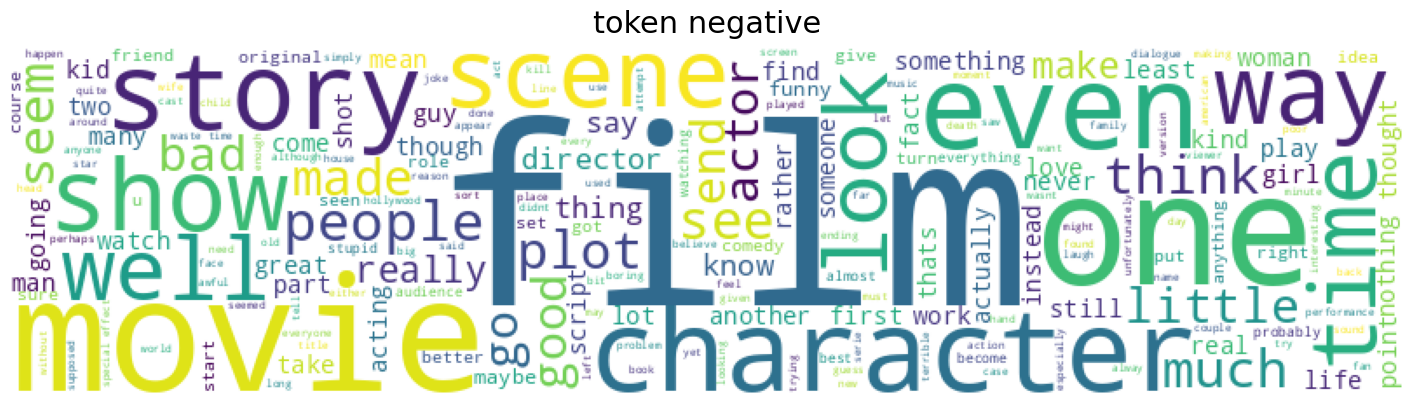

In [17]:
wc = WordCloud(
    background_color = 'white',
    width = 800
)

wc.generate(' '.join(text for text in df.loc[df['label'] == 0, 'clean_review']))
plt.figure(figsize=(18,10))
plt.title('token negative',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

## train model

In [18]:
#split

X = df['clean_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

#### BoW

In [19]:
vector_bow = CountVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_bow = vector_bow.fit_transform(X_train)
X_test_bow = vector_bow.transform(X_test)

In [20]:
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)

MultinomialNB()

In [29]:
y_pred_bow = nb_bow.predict(X_test_bow)
y_proba_bow = nb_bow.predict_proba(X_test_bow)[:, 1]

akurasi = accuracy_score(y_test, y_pred_bow)
f1 = f1_score(y_test, y_pred_bow)
precision = precision_score(y_test, y_pred_bow)
recall = recall_score(y_test, y_pred_bow)

print(f'Akurasi: {akurasi:.3f}')
print(f'f1 : {f1:.3f}')
print(f'precision : {precision:.3f}')
print(f'recall : {recall:.3f}')

Akurasi: 0.850
f1 : 0.852
precision : 0.849
recall : 0.855


In [22]:
cr = classification_report(y_test, y_pred_bow)

print(cr)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



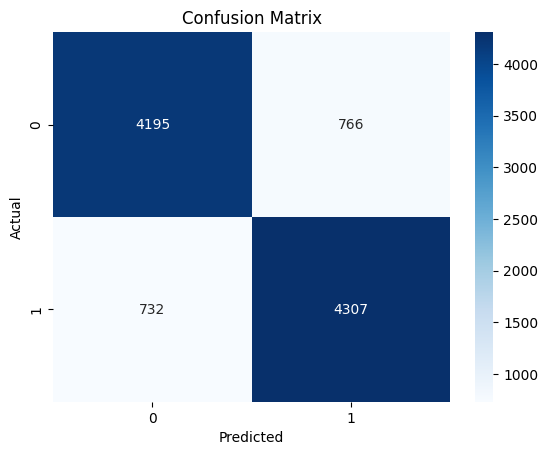

In [23]:
cm = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

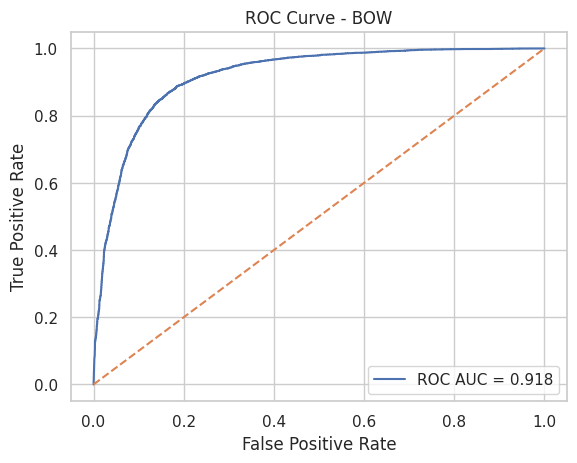

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_proba_bow)
roc_auc = auc(fpr, tpr)

sns.set(style='whitegrid', font_scale=1.0)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BOW')
plt.legend()
plt.show()

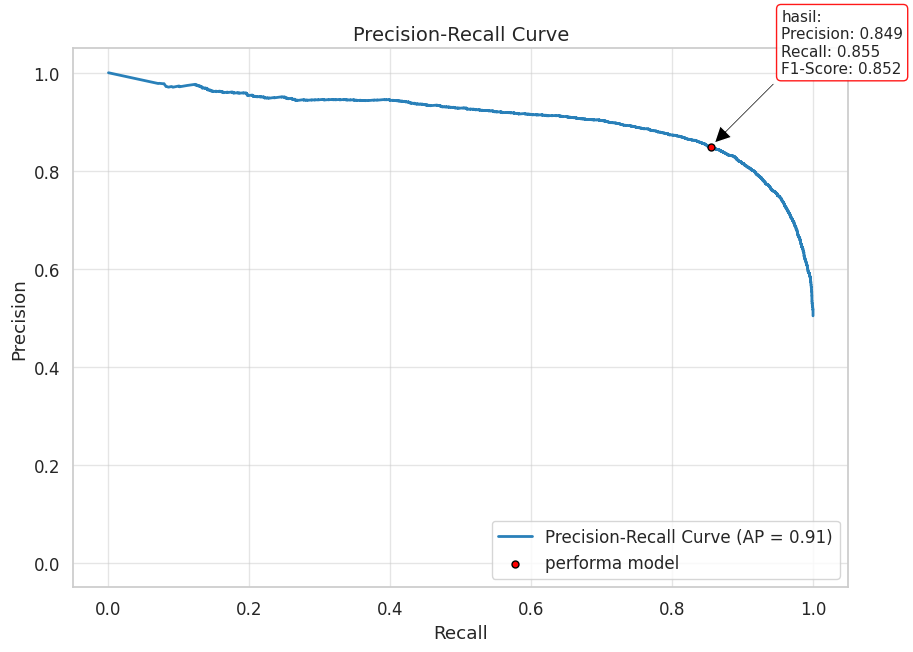

In [34]:
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_bow)
ap_score = average_precision_score(y_test, y_proba_bow)

current_recall = recall_score(y_test, y_pred_bow)
current_precision = precision_score(y_test, y_pred_bow)
current_f1 = f1_score(y_test, y_pred_bow)

sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(10, 7))

#a
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall Curve (AP = {ap_score:.2f})',
         linewidth=2, color='#2980b9')

#b
plt.scatter(current_recall, current_precision, marker='o', color='red', s=25,
            label='performa model', zorder=5, edgecolors='black')

#c
text_label = (f"hasil:\n"
              f"Precision: {current_precision:.3f}\n"
              f"Recall: {current_recall:.3f}\n"
              f"F1-Score: {current_f1:.3f}")

plt.annotate(text_label,
             xy=(current_recall, current_precision),
             xytext=(current_recall + 0.1, current_precision + 0.15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9),
             fontsize=11)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower right')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True, alpha=0.5)

plt.show()

#### TF IDF

In [24]:
vector_tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = vector_tfidf.fit_transform(X_train)
X_test_tfidf = vector_tfidf.transform(X_test)

In [25]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [32]:
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
y_proba_tfidf = nb_tfidf.predict_proba(X_test_bow)[:, 1]

akurasi = accuracy_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf)
precision = precision_score(y_test, y_pred_tfidf)
recall = recall_score(y_test, y_pred_tfidf)

print(f'Akurasi: {akurasi:.3f}')
print(f'f1 : {f1:.3f}')
print(f'precision : {precision:.3f}')
print(f'recall : {recall:.3f}')

Akurasi: 0.855
f1 : 0.858
precision : 0.848
recall : 0.868


In [27]:
cr = classification_report(y_test, y_pred_tfidf)

print(cr)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.85      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



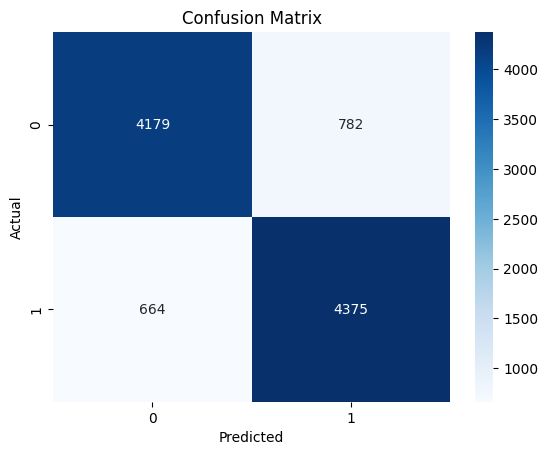

In [28]:
cm = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba_tfidf)
roc_auc = auc(fpr, tpr)

sns.set(style='whitegrid', font_scale=1.0)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TFIDF')
plt.legend()
plt.show()

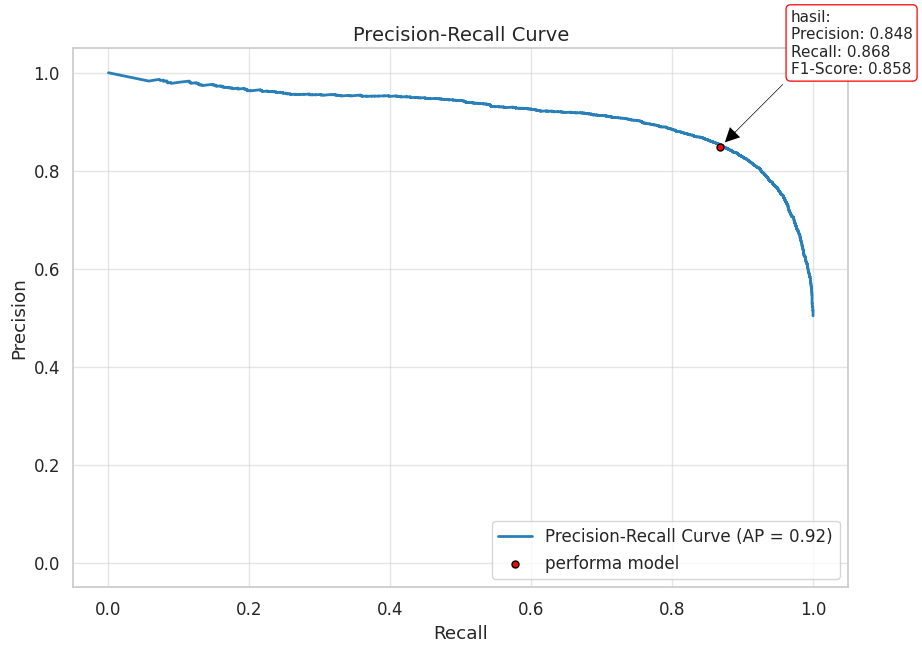

In [33]:
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_tfidf)
ap_score = average_precision_score(y_test, y_proba_tfidf)

current_recall = recall_score(y_test, y_pred_tfidf)
current_precision = precision_score(y_test, y_pred_tfidf)
current_f1 = f1_score(y_test, y_pred_tfidf)

sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(10, 7))

#a
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall Curve (AP = {ap_score:.2f})',
         linewidth=2, color='#2980b9')

#b
plt.scatter(current_recall, current_precision, marker='o', color='red', s=25,
            label='performa model', zorder=5, edgecolors='black')

#c
text_label = (f"hasil:\n"
              f"Precision: {current_precision:.3f}\n"
              f"Recall: {current_recall:.3f}\n"
              f"F1-Score: {current_f1:.3f}")

plt.annotate(text_label,
             xy=(current_recall, current_precision),
             xytext=(current_recall + 0.1, current_precision + 0.15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9),
             fontsize=11)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower right')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True, alpha=0.5)

plt.show()